In [ ]:

# Collection of imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 10.9 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Phase 1: Data Preparation
# Load the dataset
df = pd.read_csv(r"C:\Users\smadu\OneDrive\Desktop\INF 791 Applied Data Science\Assignment 01\bank-full(1).csv", sep=";")
df.head()
## number of records
print(f"Number of records: {len(df)}")

Number of records: 45211


In [72]:
## 1.1 Data Cleaning
#We start by identifying missing values (NaN) and placeholder values such as 'unknown' in the dataset. We summarize the number of such values in each column and explain the strategy for handling them.

In [6]:
# Identify missing and 'unknown' values
missing_summary = pd.DataFrame({
    'missing': df.isnull().sum(),
    'unknown': (df == 'unknown').sum(),
    'total_problematic': df.isnull().sum() + (df == 'unknown').sum()
})
print(missing_summary)

df_cleaned = df.copy()
# Drop poutcome column
df_cleaned = df_cleaned.drop(columns=['poutcome'])
# Replace 'unknown' with NaN in categorical columns
for col in ['job', 'education']:
    df_cleaned[col] = df_cleaned[col].replace('unknown', np.nan)    
# Impute with most frequent value   
imputer = SimpleImputer(strategy='most_frequent')
df_cleaned[['job', 'education']] = imputer.fit_transform(
    df_cleaned[['job', 'education']]
)

df_cleaned.head()


           missing  unknown  total_problematic
age              0        0                  0
job              0      288                288
marital          0        0                  0
education        0     1857               1857
default          0        0                  0
balance          0        0                  0
housing          0        0                  0
loan             0        0                  0
contact          0    13020              13020
day              0        0                  0
month            0        0                  0
duration         0        0                  0
campaign         0        0                  0
pdays            0        0                  0
previous         0        0                  0
poutcome         0    36959              36959
y                0        0                  0


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,no
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,92,1,-1,0,no
4,33,blue-collar,single,secondary,no,1,no,no,unknown,5,may,198,1,-1,0,no


<Figure size 800x500 with 0 Axes>

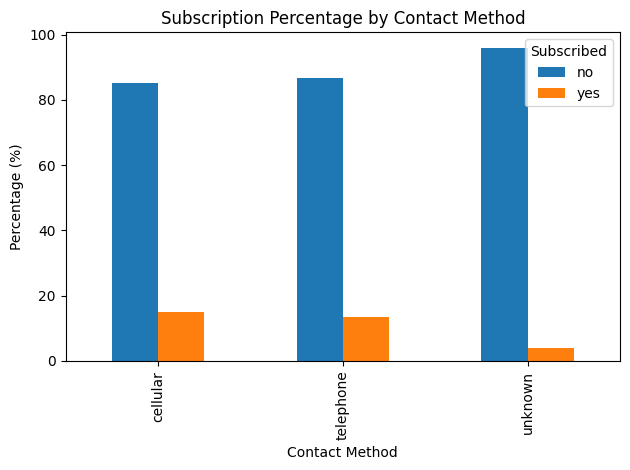

In [7]:
contact_target = pd.crosstab(df_cleaned['contact'], df_cleaned['y'])
contact_target_percent = contact_target.div(contact_target.sum(1), axis=0) * 100
# Visualize the relationship between contact method and subscription
plt.figure(figsize=(8, 5))
contact_target_percent.plot(kind='bar', stacked=False)
plt.title("Subscription Percentage by Contact Method")
plt.xlabel("Contact Method")
plt.ylabel("Percentage (%)")
plt.legend(title='Subscribed')
plt.tight_layout()
plt.show()

In [13]:
## 1.1 Feature Categorization
# We categorize each feature as either numerical or categorical. The table below lists each feature, its type, and a brief description.

In [8]:
# Categorize features
feature_types = pd.DataFrame({
    'Feature': df_cleaned.columns,
    'Type': ['numerical' if np.issubdtype(df_cleaned[col].dtype, np.number) else 'categorical' for col in df_cleaned.columns],
    'Description': [
        'Client age', 'Job type', 'Marital status', 'Education level', 'Have they defaulted on credit', 'Average balance', 'Has housing loan/mortgage',
        'Has personal/other loan', 'Communication type', 'Last contact month', 'Last contact day', 'Duration of last contact',
        'Number of contacts during campaign', 'Days since last contact', 'Number of previous contacts', 'Subscribed to term deposit'
    ]
})

feature_types


,Feature,Type,Description
0,age,numerical,Client age
1,job,categorical,Job type
2,marital,categorical,Marital status
3,education,categorical,Education level
4,default,categorical,Have they defaulted on credit
5,balance,numerical,Average balance
6,housing,categorical,Has housing loan/mortgage
7,loan,categorical,Has personal/other loan
8,contact,categorical,Communication type
9,day,numerical,Last contact month


In [15]:
## 1.2 Feature Engineering: New Features
# We create two new features to enhance model performance. Each feature is explained below.

In [9]:
# Feature 1: Age Group
# South African typical age group categorisation:
# Youth: 18-34, Adult: 35-44, Middle-aged: 45-64, Senior: 65+
df_cleaned['age_group'] = pd.cut(
    df_cleaned['age'],
    bins=[17, 34, 44, 64, np.inf],
    labels=['Youth', 'Adult', 'Middle-aged', 'Senior']
)
# Purpose: Groups clients by age for better segmentation. Age group may influence likelihood to subscribe.

# Feature 2: Contacted Before (binary)
df_cleaned['contacted_before'] = np.where((df_cleaned['pdays'] != -1), 1, 0)
# Purpose: Indicates if client was previously contacted. Prior contact may affect subscription probability.
# Using both 'previous' and 'pdays' to determine if contacted before. / pdays = -1 indicates never contacted.

# Display sample of updated data
df_cleaned[['age', 'age_group', 'previous', 'contacted_before', 'y']].head()

# Feature 3: Balance to Age 
df_cleaned['balance_to_age_ratio'] = df_cleaned['balance'] / (df_cleaned['age'] + 1)  # Add 1 to avoid division by zero



In [17]:
## 1.3 Basic Statistics and Correlation Analysis
# We compute summary statistics for numerical features and analyze correlations to guide feature selection and modeling.

                        count         mean          std     min       25%  \
age                   45211.0    40.936210    10.618762    18.0   33.0000   
balance               45211.0  1362.272058  3044.765829 -8019.0   72.0000   
day                   45211.0    15.806419     8.322476     1.0    8.0000   
duration              45211.0   258.163080   257.527812     0.0  103.0000   
campaign              45211.0     2.763841     3.098021     1.0    1.0000   
pdays                 45211.0    40.197828   100.128746    -1.0   -1.0000   
previous              45211.0     0.580323     2.303441     0.0    0.0000   
contacted_before      45211.0     0.182633     0.386369     0.0    0.0000   
balance_to_age_ratio  45211.0    32.894639    71.136513  -297.0    1.7863   

                             50%          75%            max  
age                    39.000000    48.000000      95.000000  
balance               448.000000  1428.000000  102127.000000  
day                    16.000000    21.0

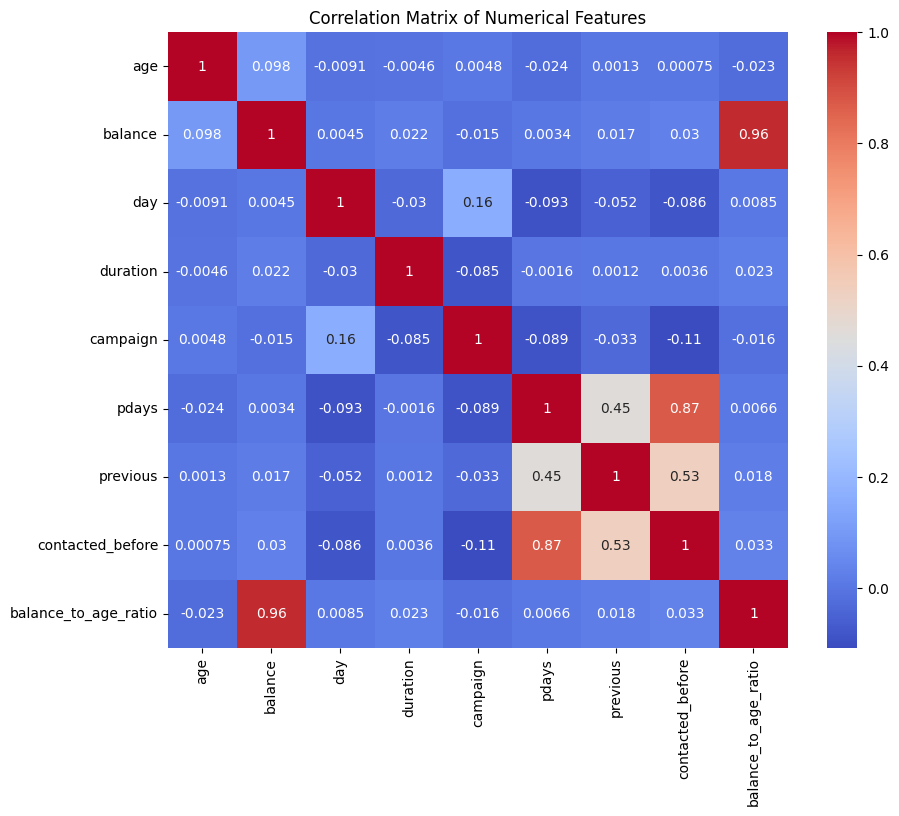

In [10]:
# Summary statistics for numerical features
num_features = df_cleaned.select_dtypes(include=[np.number]).columns
summary_stats = df_cleaned[num_features].describe().T
print(summary_stats)

# Correlation matrix
corr_matrix = df_cleaned[num_features].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [11]:
## 1.4 Data Visualisation
# We use histograms, bar charts, boxplots, and heatmaps to explore data distributions and relationships with the target variable.
df_cleaned

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,y,age_group,contacted_before,balance_to_age_ratio
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,no,Middle-aged,0,36.322034
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,no,Adult,0,0.644444
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,no,Youth,0,0.058824
3,47,blue-collar,married,secondary,no,1506,yes,no,unknown,5,may,92,1,-1,0,no,Middle-aged,0,31.375000
4,33,blue-collar,single,secondary,no,1,no,no,unknown,5,may,198,1,-1,0,no,Youth,0,0.029412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,yes,Middle-aged,0,15.865385
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,yes,Senior,0,24.013889
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,yes,Senior,1,78.287671
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,no,Middle-aged,0,11.517241


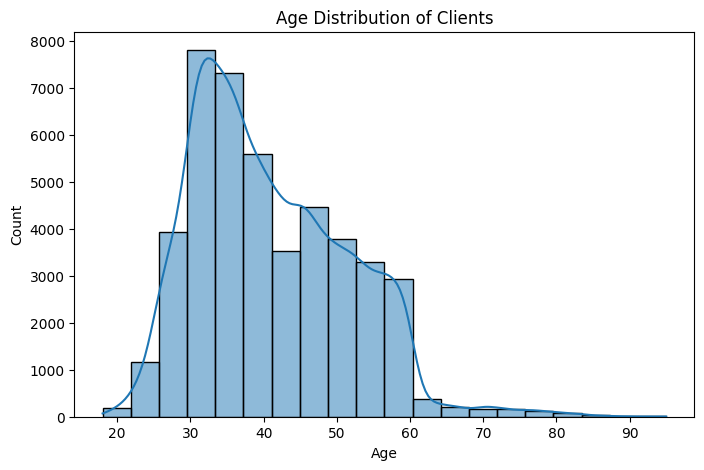

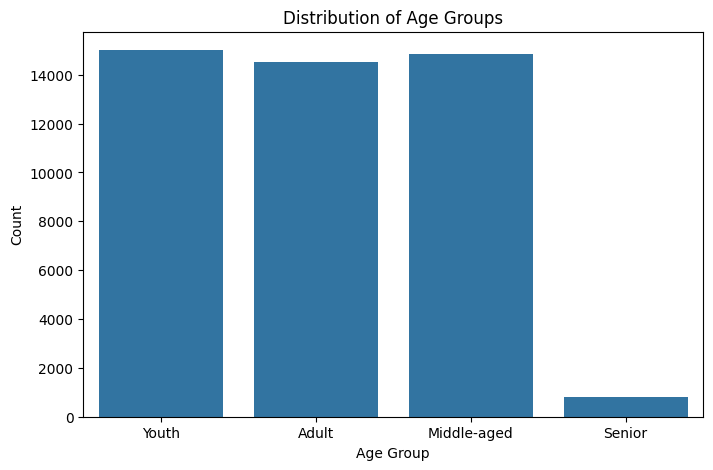

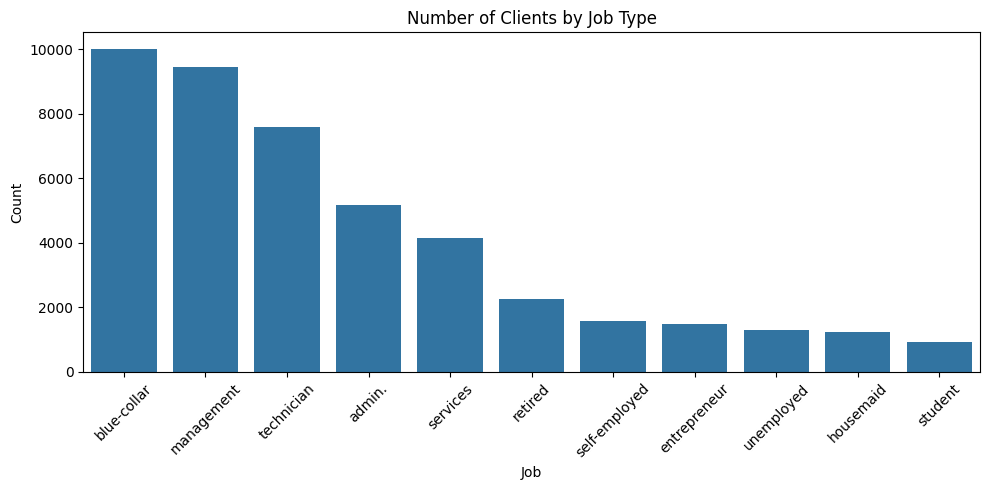

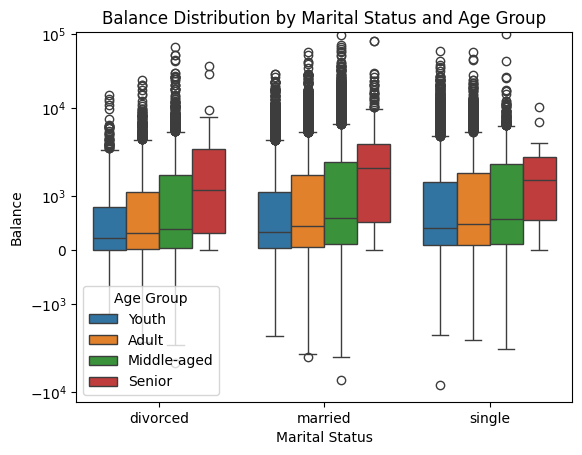

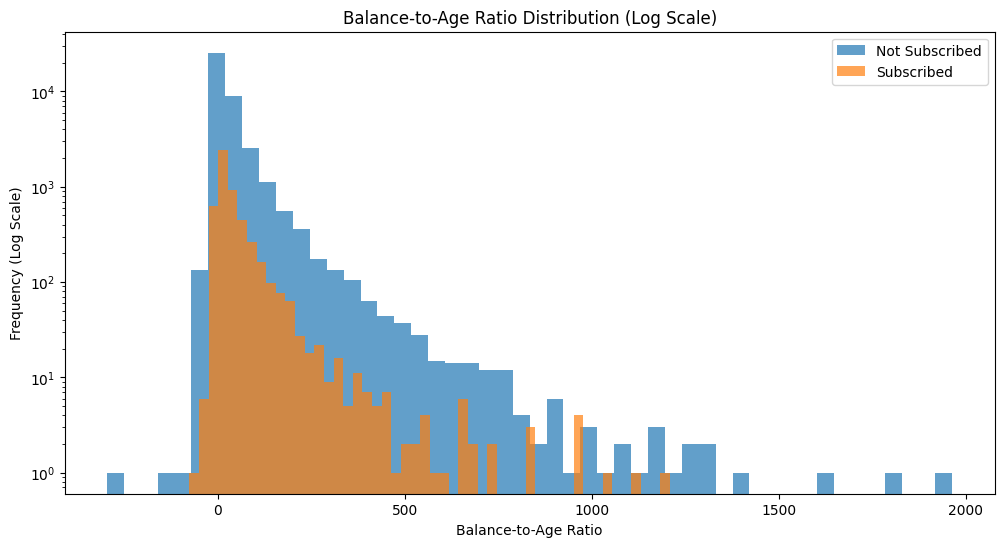

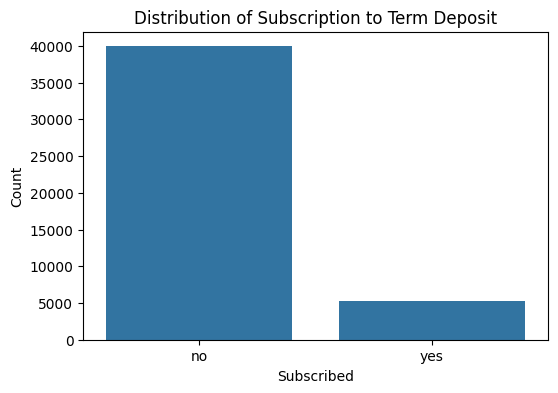

In [12]:
# Histogram of Age
plt.figure(figsize=(8,5))
sns.histplot(df_cleaned['age'], bins=20, kde=True)
plt.title('Age Distribution of Clients')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Bar chart of Age Groups
plt.figure(figsize=(8,5))
sns.countplot(x='age_group', data=df_cleaned, order=['Youth', 'Adult', 'Middle-aged', 'Senior'])
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

# Bar chart: Count of clients by job type
plt.figure(figsize=(10,5))
sns.countplot(x='job', data=df_cleaned, order=df_cleaned['job'].value_counts().index)
plt.title('Number of Clients by Job Type')
plt.xlabel('Job')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot: Balance by Marital Status and Age Group
# 1. Boxplot with symlog y-axis to compress tails
ax = sns.boxplot(
    x='marital', y='balance', hue='age_group',
    data=df_cleaned, order=['divorced','married','single'],
    whis=2.5
)
ax.set_yscale('symlog', linthresh=1500)  # tweak linthresh (e.g., 1000–3000)
ax.set_title('Balance Distribution by Marital Status and Age Group')
ax.set_xlabel('Marital Status'); ax.set_ylabel('Balance')
ax.legend(title='Age Group')

# Histogram of the Balance-to-Age Ratio distribution on the log scale frequency
## Helps visualize the distribution of the new feature and its relationship to the target variable
plt.figure(figsize=(12, 6))

# Plot histograms for both classes with log scale on y-axis
plt.hist(df_cleaned[df_cleaned['y'] == 'no']['balance_to_age_ratio'], 
         alpha=0.7, label='Not Subscribed', bins=50, log=True)
plt.hist(df_cleaned[df_cleaned['y'] == 'yes']['balance_to_age_ratio'], 
         alpha=0.7, label='Subscribed', bins=50, log=True)

plt.title('Balance-to-Age Ratio Distribution (Log Scale)')
plt.xlabel('Balance-to-Age Ratio')
plt.ylabel('Frequency (Log Scale)')
plt.legend()
plt.show()

# Histogtam of the target variable
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=df_cleaned)
plt.title('Distribution of Subscription to Term Deposit')
plt.xlabel('Subscribed')
plt.ylabel('Count')
plt.show()

In [21]:
## 1.5 Data Preprocessing: Additional Data Transformations
# We drop irrelevant features, ensure consistent data types, and prepare the final dataset for modeling.

In [13]:
# Drop leakage-prone and irrelevant features
df_model = df_cleaned.drop(columns=['duration'])
# Convert all categoraical to object type
for col in df_model.select_dtypes(include=['category']).columns:
    df_model[col] = df_model[col].astype('object')

## Skewness correction and scaling for numerical features
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
# If you added log_balance, keep that and consider dropping raw balance
num_cols = [c for c in num_cols if c != 'balance']

pt = PowerTransformer(method='yeo-johnson')  # handles zeros/negatives
df_model[num_cols] = pt.fit_transform(df_model[num_cols])

scaler = MinMaxScaler()
df_model[num_cols] = scaler.fit_transform(df_model[num_cols])
# Final structure check
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   45211 non-null  float64
 1   job                   45211 non-null  object 
 2   marital               45211 non-null  object 
 3   education             45211 non-null  object 
 4   default               45211 non-null  object 
 5   balance               45211 non-null  int64  
 6   housing               45211 non-null  object 
 7   loan                  45211 non-null  object 
 8   contact               45211 non-null  object 
 9   day                   45211 non-null  float64
 10  month                 45211 non-null  object 
 11  campaign              45211 non-null  float64
 12  pdays                 45211 non-null  float64
 13  previous              45211 non-null  float64
 14  y                     45211 non-null  object 
 15  age_group          

In [102]:
## 1.6 Data Encoding
# We apply one-hot encoding to nominal categorical variables and ensure all features are numeric for modeling.

In [14]:
# Identify nominal categorical variables
nominal_cols = [col for col in df_model.columns if df_model[col].dtype == 'object' and col != 'y']
# Apply one-hot encoding
df_encoded = pd.get_dummies(df_model, columns=nominal_cols, drop_first=True)
# Encode target variable
df_encoded['y'] = (df_encoded['y'] == 'yes').astype(int)
# Check final structure and data types
print(df_encoded.info())
df_encoded.head()
# export the head of the dataframe to csv
# df_encoded.head().to_csv('df_encoded_head3.csv', index=False)
# df_encoded.to_csv('df_encoded_full5.csv', index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   age                    45211 non-null  float64
 1   balance                45211 non-null  int64  
 2   day                    45211 non-null  float64
 3   campaign               45211 non-null  float64
 4   pdays                  45211 non-null  float64
 5   previous               45211 non-null  float64
 6   y                      45211 non-null  int64  
 7   contacted_before       45211 non-null  float64
 8   balance_to_age_ratio   45211 non-null  float64
 9   job_blue-collar        45211 non-null  bool   
 10  job_entrepreneur       45211 non-null  bool   
 11  job_housemaid          45211 non-null  bool   
 12  job_management         45211 non-null  bool   
 13  job_retired            45211 non-null  bool   
 14  job_self-employed      45211 non-null  bool   
 15  jo

,age,balance,day,campaign,pdays,previous,y,contacted_before,balance_to_age_ratio,job_blue-collar,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,age_group_Middle-aged,age_group_Senior,age_group_Youth
0,0.731404,2143,0.195769,0.0,0.0,0.0,0,0.0,0.837452,False,...,False,False,False,True,False,False,False,True,False,False
1,0.570729,29,0.195769,0.0,0.0,0.0,0,0.0,0.827577,False,...,False,False,False,True,False,False,False,False,False,False
2,0.395437,2,0.195769,0.0,0.0,0.0,0,0.0,0.827239,False,...,False,False,False,True,False,False,False,False,False,True
3,0.609772,1506,0.195769,0.0,0.0,0.0,0,0.0,0.836405,True,...,False,False,False,True,False,False,False,True,False,False
4,0.395437,1,0.195769,0.0,0.0,0.0,0,0.0,0.827221,True,...,False,False,False,True,False,False,False,False,False,True


In [195]:
## Export the preprocessed data into a csv file called sibusiso_preprocessed_bank_data.csv
preprocess_output = df_encoded.copy()
preprocess_output.to_csv("sibusiso_preprocessed_bank_data2.csv", index=False)

In [ ]:
# Part 2 – Supervised Learning
# We train and compare classification models (Logistic Regression and Random Forest) to predict term deposit subscription.

In [22]:
# Split data into train and test sets
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, stratify=y)

# Ensure both train and test have the same columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)


#Applying SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Applying scaler for logistic regression model
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Calculate class ratio for XGBoost
class_ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
                        Threshold  Accuracy  Precision  Recall  F1 Score  \
Model                                                                      
Logistic Regression  7.648337e-04  0.116997   0.116997     1.0  0.209484   
Random Forest        0.000000e+00  0.116997   0.116997     1.0  0.209484   
Naive Bayes          7.168242e-08  0.116997   0.116997     1.0  0.209484   
XGBoost              1.475631e-04  0.116997   0.116997     1.0  0.209484   
LightGBM             3.010407e-03  0.1169

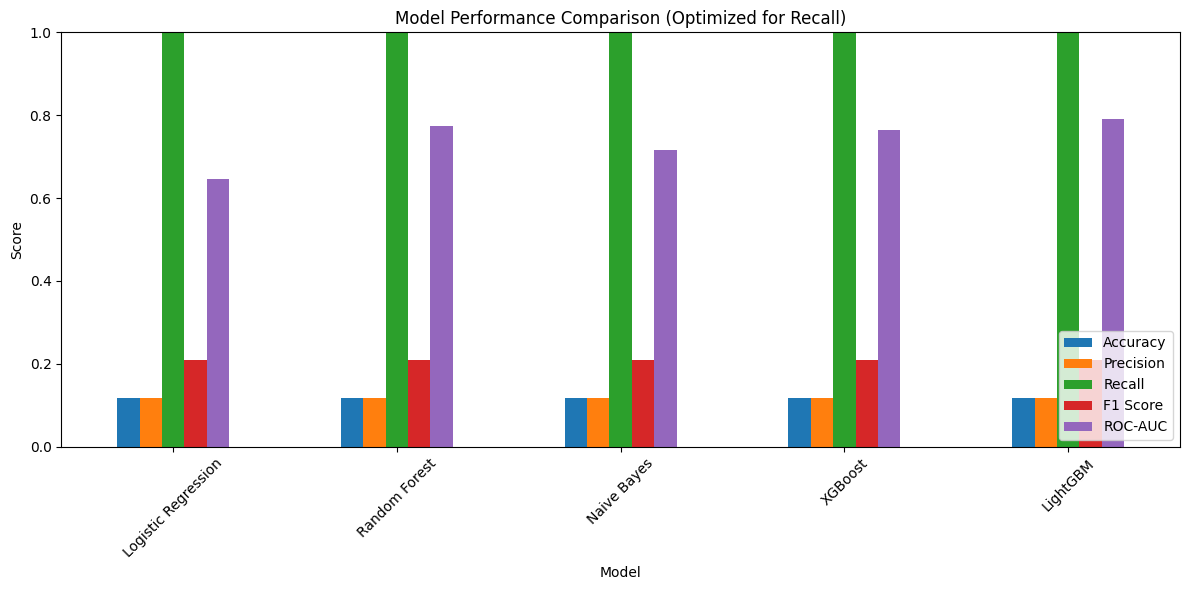

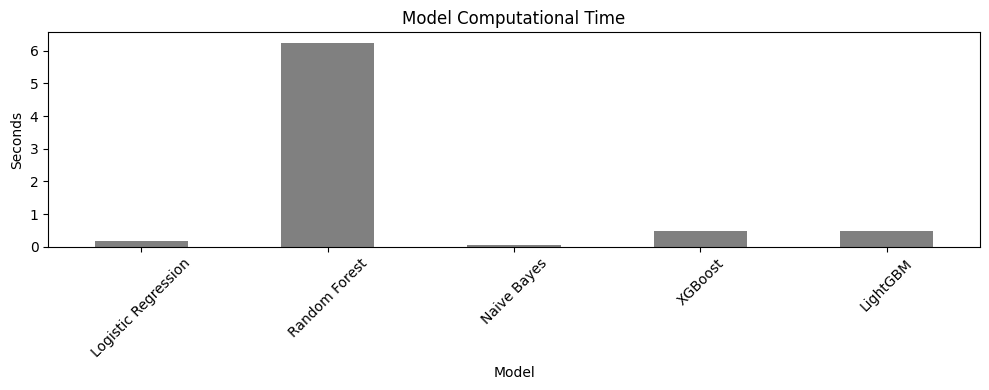

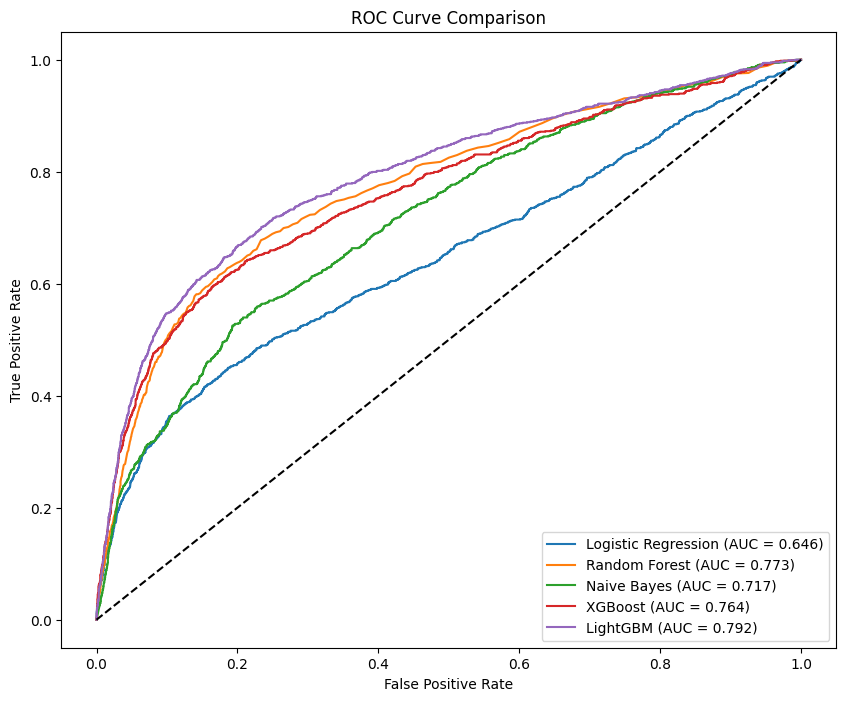

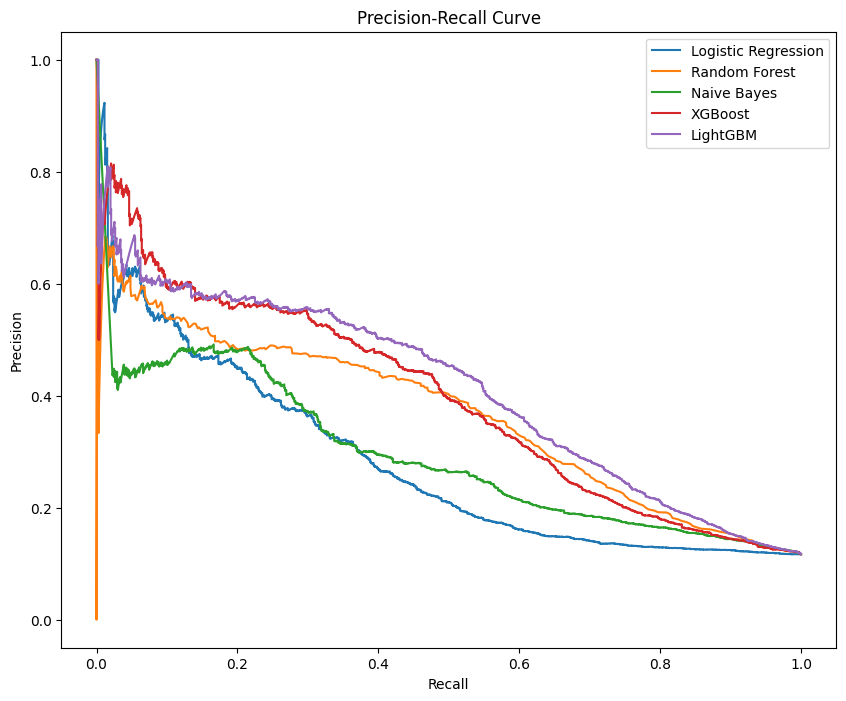

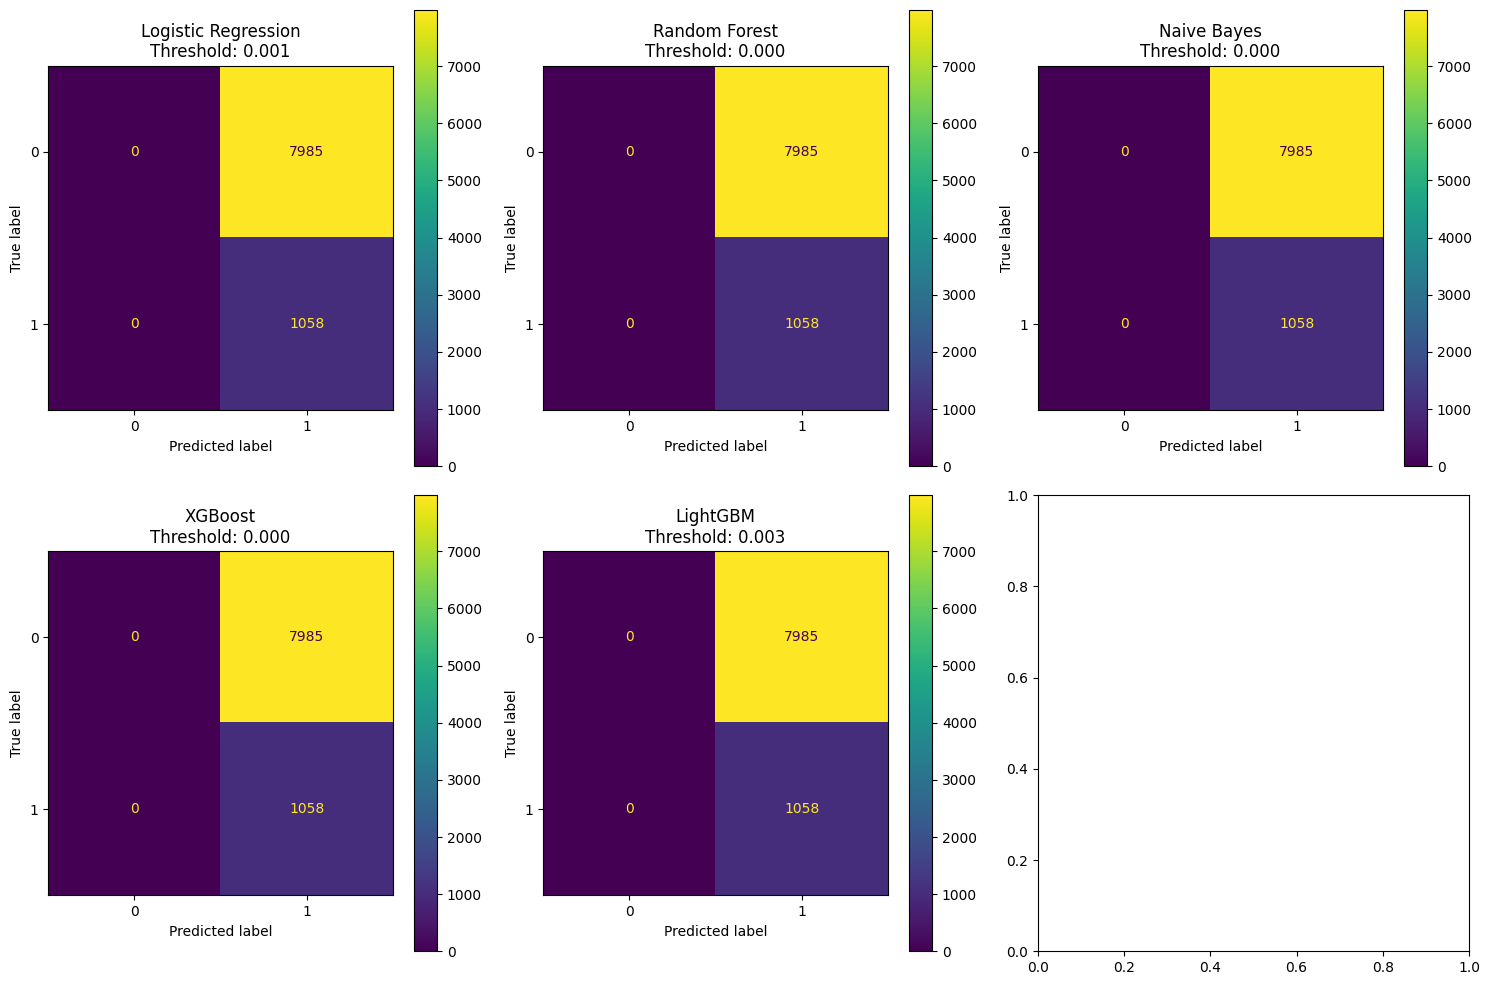

In [ ]:
# # Train models
# models = {}
# model_times = {}
# model_probas = {}

# # Logistic Regression
# start_lr = time.time()
# lr = LogisticRegression(max_iter=1000, class_weight='balanced')
# lr.fit(X_train_scaled, y_train_resampled)
# lr_proba = lr.predict_proba(X_test_scaled)[:, 1]
# models['Logistic Regression'] = lr
# model_probas['Logistic Regression'] = lr_proba
# model_times['Logistic Regression'] = time.time() - start_lr

# # Random Forest
# start_rf = time.time()
# rf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced_subsample', n_jobs=-1)
# rf.fit(X_train_resampled, y_train_resampled)
# rf_proba = rf.predict_proba(X_test)[:, 1]
# models['Random Forest'] = rf
# model_probas['Random Forest'] = rf_proba
# model_times['Random Forest'] = time.time() - start_rf

# # Naive Bayes
# start_nb = time.time()
# nb = GaussianNB()
# nb.fit(X_train_resampled, y_train_resampled)
# nb_proba = nb.predict_proba(X_test)[:, 1]
# models['Naive Bayes'] = nb
# model_probas['Naive Bayes'] = nb_proba
# model_times['Naive Bayes'] = time.time() - start_nb

# # XGBoost
# start_xgb = time.time()
# xgb = XGBClassifier(
#     n_estimators=200,
#     random_state=42,
#     scale_pos_weight=class_ratio,
#     eval_metric='logloss',
#     n_jobs=-1
# )
# xgb.fit(X_train_resampled, y_train_resampled)
# xgb_proba = xgb.predict_proba(X_test)[:, 1]
# models['XGBoost'] = xgb
# model_probas['XGBoost'] = xgb_proba
# model_times['XGBoost'] = time.time() - start_xgb

# # LightGBM
# start_lgbm = time.time()
# lgbm = LGBMClassifier(
#     n_estimators=200,
#     random_state=42,
#     class_weight='balanced',
#     n_jobs=-1
# )
# lgbm.fit(X_train_resampled, y_train_resampled)
# lgbm_proba = lgbm.predict_proba(X_test)[:, 1]
# models['LightGBM'] = lgbm
# model_probas['LightGBM'] = lgbm_proba
# model_times['LightGBM'] = time.time() - start_lgbm
# from sklearn.metrics import precision_recall_curve
# # Function to find optimal threshold for a target recall
# def find_optimal_threshold(y_true, y_proba, target_recall=0.7):
#     precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    
#     # Find the threshold that gives at least the target recall
#     for i, rec in enumerate(recalls):
#         if rec >= target_recall:
#             return thresholds[i]
    
#     # If target recall not achievable, return the threshold with highest recall
#     return thresholds[np.argmax(recalls)]

# # Evaluate models with different thresholds
# metrics = []

# for name, proba in model_probas.items():
#     # Find optimal threshold for 70% recall
#     optimal_threshold = find_optimal_threshold(y_test, proba, target_recall=0.7)
#     preds = (proba >= optimal_threshold).astype(int)
    
#     metrics.append({
#         'Model': name,
#         'Threshold': optimal_threshold,
#         'Accuracy': accuracy_score(y_test, preds),
#         'Precision': precision_score(y_test, preds, zero_division=0),
#         'Recall': recall_score(y_test, preds),
#         'F1 Score': f1_score(y_test, preds),
#         'ROC-AUC': roc_auc_score(y_test, proba),
#         'Time (s)': model_times[name]
#     })

# # Create DataFrame for metrics
# metrics_df = pd.DataFrame(metrics).set_index('Model')
# print(metrics_df)

# # Plot performance metrics
# metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
# ax = metrics_df[metrics_to_plot].plot(kind='bar', figsize=(12, 6))
# plt.title('Model Performance Comparison (Optimized for Recall)')
# plt.ylabel('Score')
# plt.ylim(0, 1)
# plt.xticks(rotation=45)
# plt.legend(loc='lower right')
# plt.tight_layout()
# plt.show()

# # Plot computational time
# metrics_df['Time (s)'].plot(kind='bar', color='gray', figsize=(10, 4))
# plt.title('Model Computational Time')
# plt.ylabel('Seconds')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Plot ROC Curve
# plt.figure(figsize=(10, 8))
# for name, proba in model_probas.items():
#     fpr, tpr, _ = roc_curve(y_test, proba)
#     plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, proba):.3f})')

# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve Comparison')
# plt.legend(loc='lower right')
# plt.show()

# # Plot Precision-Recall Curve
# plt.figure(figsize=(10, 8))
# for name, proba in model_probas.items():
#     precision, recall, _ = precision_recall_curve(y_test, proba)
#     plt.plot(recall, precision, label=name)

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend(loc='upper right')
# plt.show()

# # Display confusion matrices for each model
# fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# axes = axes.ravel()

# for i, (name, proba) in enumerate(model_probas.items()):
#     optimal_threshold = find_optimal_threshold(y_test, proba, target_recall=0.7)
#     preds = (proba >= optimal_threshold).astype(int)
    
#     cm = confusion_matrix(y_test, preds)
#     disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#     disp.plot(ax=axes[i], values_format='d')
#     axes[i].set_title(f'{name}\nThreshold: {optimal_threshold:.3f}')

# plt.tight_layout()
# plt.show()

In [24]:
## Cell includes splitting, scaling for logistic regression, training and testing models ##
# Train Logistic Regression
start_lr = time.time()
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train_resampled)
# Predict
lr_pred = lr.predict(X_test_scaled)
lr_proba = lr.predict_proba(X_test_scaled)[:,1]
lr_time = time.time() - start_lr

# Train Random Forest
start_rf = time.time()
rf = RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced_subsample',n_jobs=-1)
rf.fit(X_train_resampled, y_train_resampled)
# Predict
rf_pred = rf.predict(X_test)
rf_proba = rf.predict_proba(X_test)[:,1]
rf_time = time.time() - start_rf

# Train Naive Bayes
start_nb = time.time()
nb = GaussianNB()
nb.fit(X_train_resampled, y_train_resampled)
# Predict
nb_pred = nb.predict(X_test)
nb_proba = nb.predict_proba(X_test)[:,1]
nb_time = time.time() - start_nb

In [23]:
## additional
# Train XGBoost
start_xgb = time.time()
xgb = XGBClassifier(
    n_estimators=200,
    random_state=42,
    scale_pos_weight=class_ratio,
    eval_metric='logloss',
    n_jobs=-1
)
xgb.fit(X_train_resampled, y_train_resampled)
xgb_proba = xgb.predict_proba(X_test)[:, 1]
xgb_pred = xgb.predict(X_test)
xgb_time = time.time() - start_xgb
# LightGBM
start_lgbm = time.time()
lgbm = LGBMClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
lgbm.fit(X_train_resampled, y_train_resampled)
lgbm_proba = lgbm.predict_proba(X_test)[:, 1]
lgbm_pred = lgbm.predict(X_test)
lgbm_time = time.time() - start_lgbm

[LightGBM] [Info] Number of positive: 31937, number of negative: 31937
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 63874, number of used features: 41
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


In [226]:
base = max(y.mean(), 1 - y.mean())
print("Majority baseline accuracy:", round(base, 3))

Majority baseline accuracy: 0.883


                     Accuracy  Precision    Recall  F1 Score   ROC-AUC  \
Model                                                                    
Logistic Regression  0.860113   0.374545  0.292060  0.328200  0.645893   
Random Forest        0.881787   0.489796  0.249527  0.330620  0.773169   
Naive Bayes          0.837222   0.318102  0.342155  0.329690  0.716805   
XGBoost              0.822515   0.343266  0.566163  0.427399  0.763782   
LightGBM             0.889307   0.559006  0.255198  0.350422  0.791641   

                     Time (s)  
Model                          
Logistic Regression  0.143981  
Random Forest        7.025281  
Naive Bayes          0.075818  
XGBoost              0.678380  
LightGBM             0.712582  


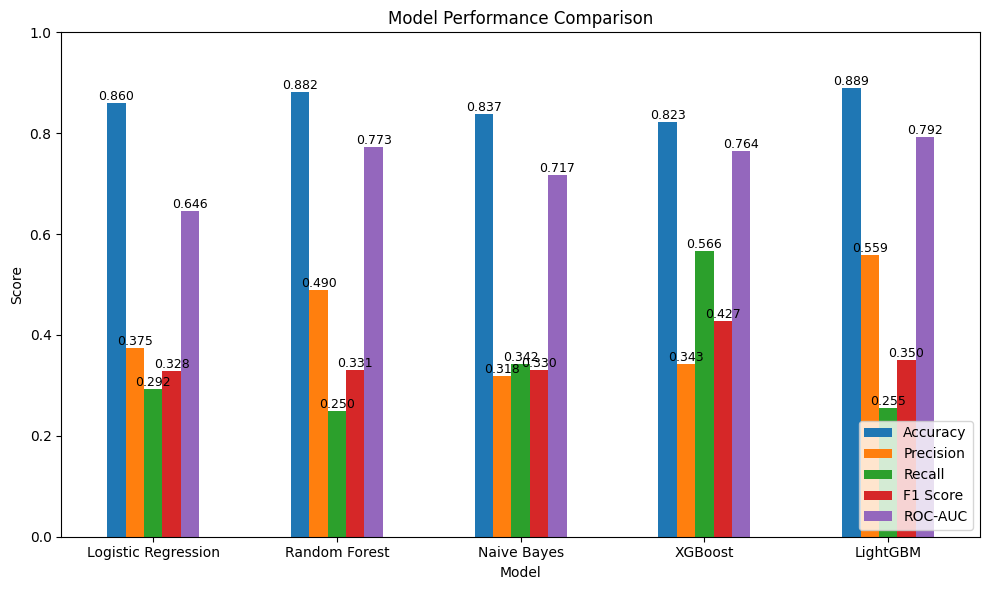

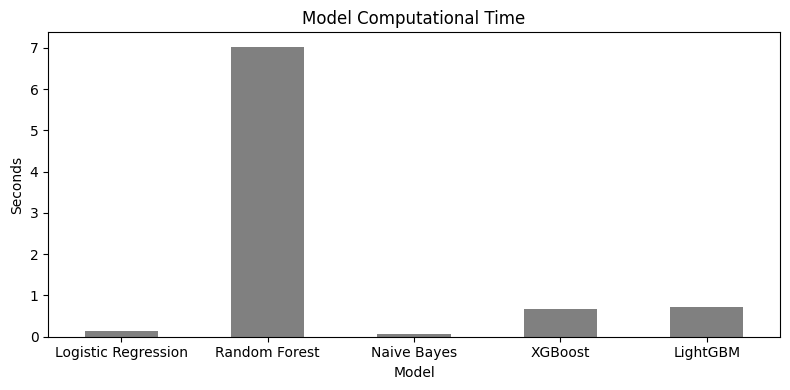

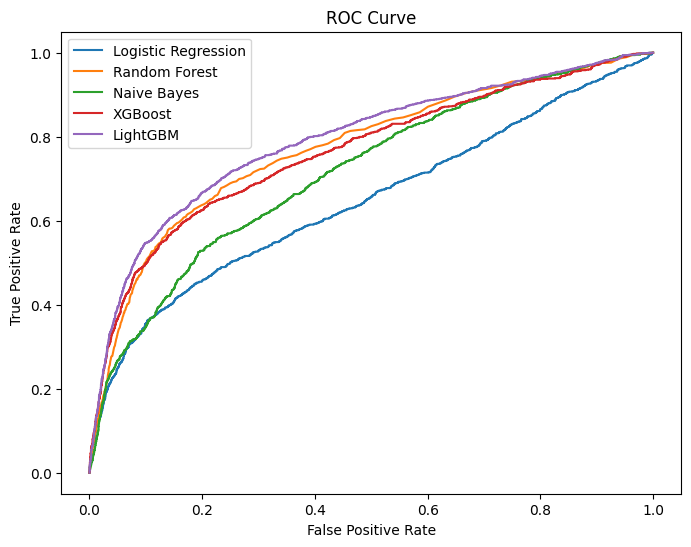

In [25]:
# Evaluate models
# Collect metrics for each model
metrics = []

def get_metrics(y_true, y_pred, y_proba, elapsed):
    return {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1 Score': f1_score(y_true, y_pred),
        'ROC-AUC': roc_auc_score(y_true, y_proba),
        'Time (s)': elapsed
    }



metrics.append({'Model': 'Logistic Regression', **get_metrics(y_test, lr_pred, lr_proba, lr_time)})
metrics.append({'Model': 'Random Forest', **get_metrics(y_test, rf_pred, rf_proba, rf_time)})
metrics.append({'Model': 'Naive Bayes', **get_metrics(y_test, nb_pred, nb_proba, nb_time)})
metrics.append({'Model': 'XGBoost', **get_metrics(y_test, xgb_pred, xgb_proba, xgb_time)})
metrics.append({'Model': 'LightGBM', **get_metrics(y_test, lgbm_pred, lgbm_proba, lgbm_time)})

# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics).set_index('Model')
print(metrics_df)
# Plot bar graphs for each metric (except time)
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
ax = metrics_df[metrics_to_plot].plot(kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# Plot computational time separately
metrics_df['Time (s)'].plot(kind='bar', color='gray', figsize=(8,4))
plt.title('Model Computational Time')
plt.ylabel('Seconds')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ROC Curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)
fpr_nb, tpr_nb, _ = roc_curve(y_test, nb_proba)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_proba)
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_test, lgbm_proba)
plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes')
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_lgbm, tpr_lgbm, label='LightGBM')
# plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()



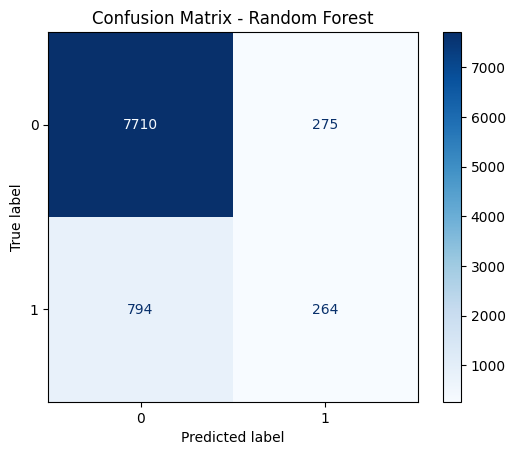

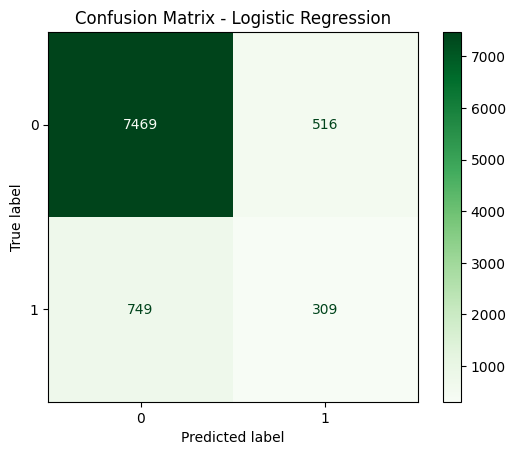

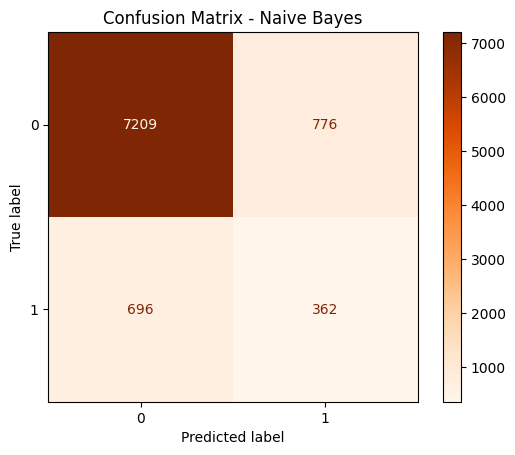

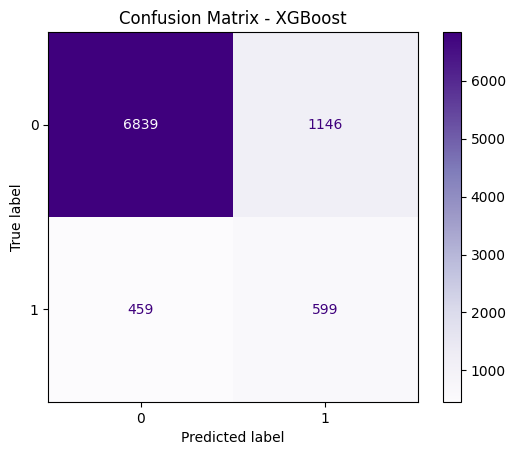

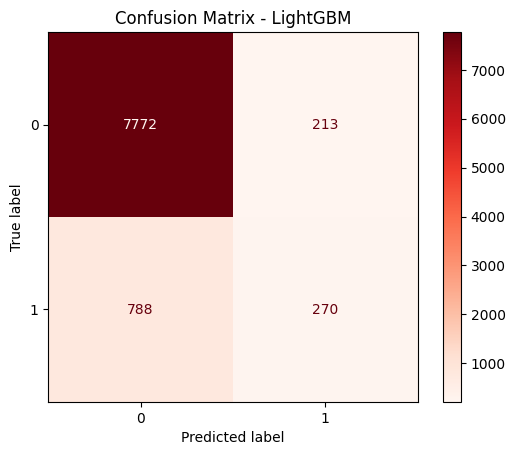

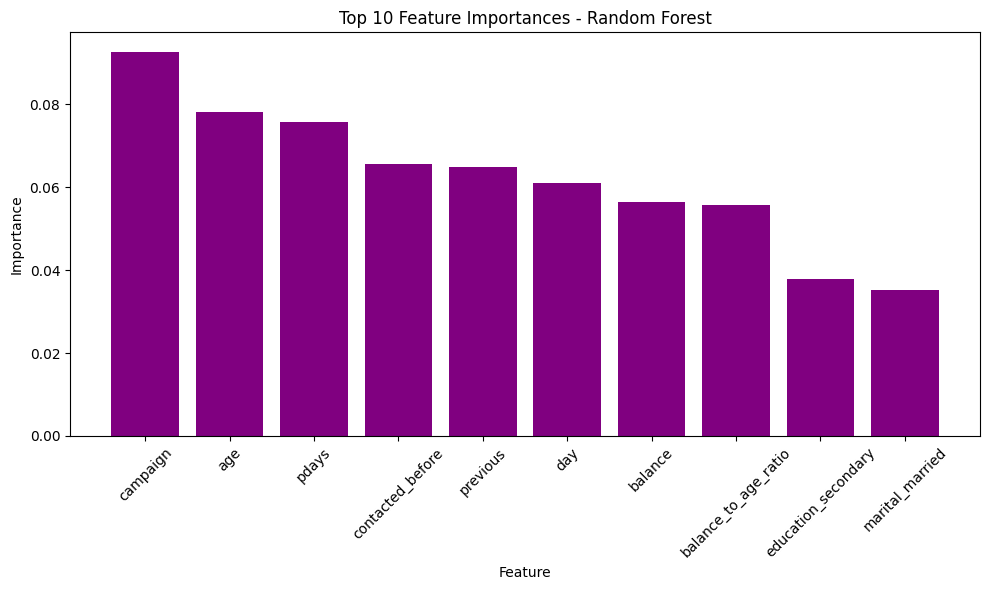

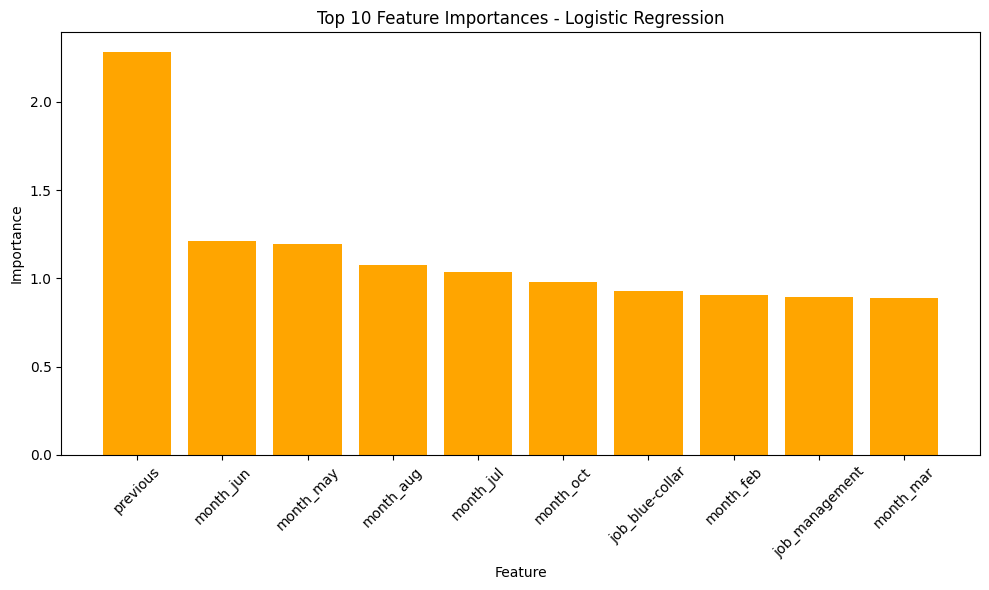

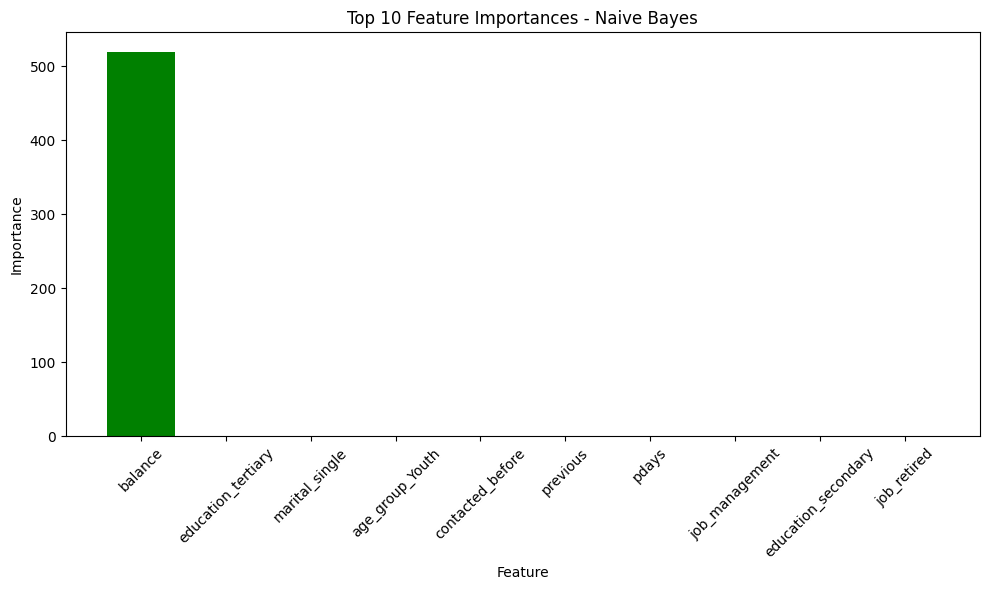

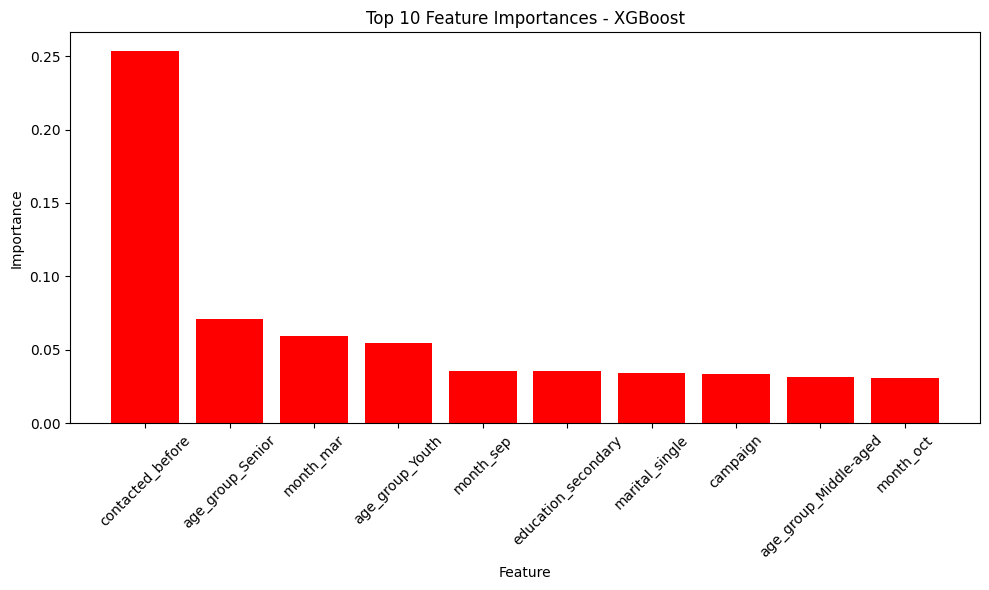

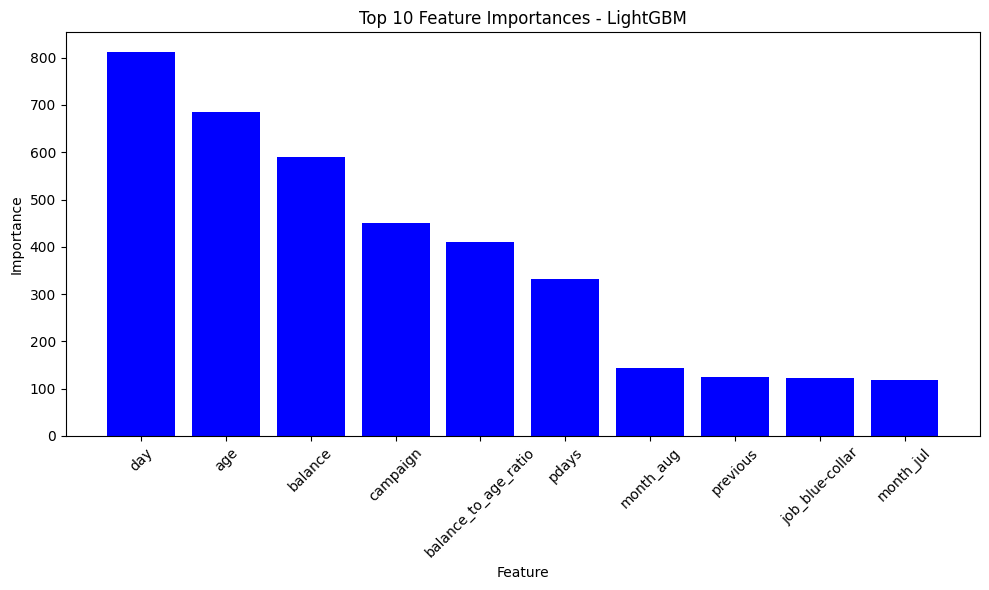

In [27]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, lr_pred)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr)
disp_lr.plot(cmap='Greens')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test, nb_pred)
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb)
disp_nb.plot(cmap='Oranges')
plt.title('Confusion Matrix - Naive Bayes')
plt.show()

# Confusion Matrix for XGBoost
cm_xgb = confusion_matrix(y_test, xgb_pred)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(cmap='Purples')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# Confusion Matrix for LightGBM
cm_lgbm = confusion_matrix(y_test, lgbm_pred)
disp_lgbm = ConfusionMatrixDisplay(confusion_matrix=cm_lgbm)
disp_lgbm.plot(cmap='Reds')
plt.title('Confusion Matrix - LightGBM')
plt.show()

# Bar graph: Feature importance (Random Forest)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.bar([X.columns[i] for i in indices[:10]], importances[indices[:10]], color='purple')
plt.title('Top 10 Feature Importances - Random Forest')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Bar graph: Feature importance (logistic regression)
importances = lr.coef_[0]
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.bar([X.columns[i] for i in indices[:10]], importances[indices[:10]], color='orange')
plt.title('Top 10 Feature Importances - Logistic Regression')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar graph: Feature importance (Naive Bayes)
importances = nb.theta_[1] - nb.theta_[0]
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.bar([X.columns[i] for i in indices[:10]], importances[indices[:10]], color='green')
plt.title('Top 10 Feature Importances - Naive Bayes')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Bar graph: Feature importance (XGBoost)
importances = xgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.bar([X.columns[i] for i in indices[:10]], importances[indices[:10]], color='red')
plt.title('Top 10 Feature Importances - XGBoost')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Bar graph: Feature importance (LightGBM)
importances = lgbm.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10,6))
plt.bar([X.columns[i] for i in indices[:10]], importances[indices[:10]], color='blue')
plt.title('Top 10 Feature Importances - LightGBM')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

